# Lung Nodule Malignancy Detection Using LUNA16 Image Subset
In this notebook, the target is to make a deep learning classification model using convolutional neural networks (CNNs) to classify long nodules as malignant or benign. The dataset has been taken as a subset of **LUNA 16**, which was employed for image segmentation task. The images have been already segmented for us and have been given in HDF5 format, which will be used in thie notebook. The dataset can be accessed [here](https://www.kaggle.com/datasets/kmader/lungnodemalignancy/code).

For this task, pre-trained CNNs could also be employed, like **EfficientNet B7**. More information about it can be accessed [here](https://arxiv.org/abs/1905.11946). But we are not using it since we have grayscale images.

In this notebook, we will make a CNN by manually adding convolutional and pooling layers.

## Importing Libraries

In [ ]:
from __future__ import print_function, division

In [ ]:

%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import torch
# from skimage.util.montage import montage2d
# from skimage.color import label2rgb
import h5py
import pylab, os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.layers import Dense
from keras.layers import Conv2D, BatchNormalization, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!nvidia-smi

Thu Aug 18 18:40:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print('TF version: %s' % str(tf.__version__))
print('Keras version: %s' % str(keras.__version__))
print('Torch version: %s' % str(torch.__version__))

TF version: 2.8.2
Keras version: 2.8.0
Torch version: 1.12.1+cu113


## Loading Dataset From Kaggle
Before proceeding further, we'll first download the original dataset from **Kaggle**.

In [ ]:
!pip install -q kaggle

In [ ]:
 !mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          12088        365  1.0              
zusmani/petrolgas-prices-worldwide                              Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33            952         70  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           7008        202  0.9705882        
ruchi798/data-science-job-salaries                          

In [ ]:
!kaggle datasets download -d kmader/lungnodemalignancy

 98% 93.0M/94.9M [00:01<00:00, 73.6MB/s]
100% 94.9M/94.9M [00:01<00:00, 65.8MB/s]


In [ ]:
! mkdir dataset

In [ ]:
! unzip lungnodemalignancy.zip -d dataset

Archive:  lungnodemalignancy.zip
  inflating: dataset/all_patches.hdf5  
  inflating: dataset/ct_tiles.tif    
  inflating: dataset/malignancy.csv  


## Loading the Dataset

In [ ]:
# loading dataset from file
output = os.path.join('..', '/content/drive/My Drive/LC/')

with h5py.File(os.path.join(output, 'all_patches.hdf5'), 'r') as luna_16:
  slices = luna_16['ct_slices']
  classes = luna_16['slice_class']

  print('Dataset: %s' % str(slices.shape))
  print('Dataset: %s' % str(classes.shape))

Dataset: (6691, 64, 64)
Dataset: (6691, 1)


In [ ]:
slices

<Closed HDF5 dataset>

In [ ]:
file = h5py.File('/content/drive/My Drive/LC/all_patches.hdf5', 'r')
print(list(file.keys()))

['ct_slices', 'slice_class']


In [ ]:
ct_slices = file['ct_slices']
slice_class = file['slice_class']

ct_slices = np.array(ct_slices)
slice_class = file['slice_class']

ct_slices.shape

(6691, 64, 64)

In [ ]:
slice_class.shape

(6691, 1)

In [ ]:
ct_slices[1]

array([[-670., -713., -738., ..., -909., -939., -948.],
       [-746., -806., -827., ..., -930., -968., -959.],
       [-799., -851., -861., ..., -943., -979., -981.],
       ...,
       [  18.,    8.,    9., ...,  -88.,  -91., -103.],
       [ -10.,    2.,   12., ...,  -97., -102., -107.],
       [ -40.,   -6.,   14., ...,  -95.,  -99.,  -97.]], dtype=float32)

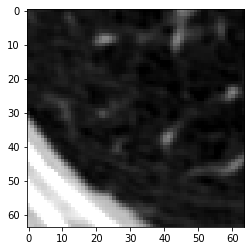

In [ ]:
ct_slices_patch = np.clip(ct_slices, -1000, 320)
pylab.imshow(ct_slices_patch[8], cmap=pylab.cm.gray)

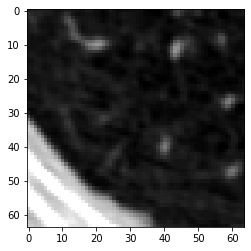

In [ ]:
ct_slices_patch = np.clip(ct_slices, -1000, 320)
pylab.imshow(ct_slices_patch[9], cmap=pylab.cm.gray)

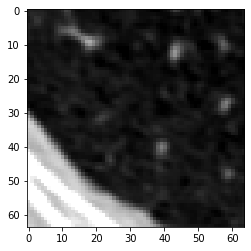

In [ ]:
ct_slices_patch = np.clip(ct_slices, -1000, 320)
pylab.imshow(ct_slices_patch[10], cmap=pylab.cm.gray)

In [ ]:
ct_slices_patch.max(), ct_slices_patch.min()

(320.0, -1000.0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Splicing and Reformating
In this step, we reformat and splice the data. The dataset will be split into two sets, train and test with **80%** samples are placed in training while **20%** of samples are placed in test set. Before splicing the data, we need to scale the data such that values are placed in a range of 0, 1

### Data Trnsformation

In [ ]:
# ct_slices_patch = ct_slices_patch.reshape(6691, 64, 64, 1)

X_scaled = (np.expand_dims(ct_slices, -1) - np.mean(ct_slices)) / np.std(ct_slices)
Y_scaled = to_categorical(slice_class)

X_scaled.shape, Y_scaled.shape

((6691, 64, 64, 1), (6691, 2))

### Data Splicing

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, 
                                                    Y_scaled, 
                                                    test_size=0.2, 
                                                    random_state=123,
                                                    stratify=slice_class)

In [ ]:
# print shapes of training and testing datasets
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(5352, 64, 64, 1)
(1339, 64, 64, 1)
(5352, 2)
(1339, 2)


## Attempt for TL

In [ ]:
from keras.models import Model
from keras.layers import Input

In [ ]:
eff = EfficientNetB7(weights='imagenet', 
                        include_top= 'False')

input_tensor = Input(shape=None)
x = Conv2D(3,(3,3),padding='same')(input_tensor)
x = Dense(1, activation='sigmoid')(x)
out = eff(x)
model = Model(inputs=input_tensor, outputs=out)

In [ ]:
# compiling the model
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
  )

In [ ]:
%%time
history = model.fit(X_train,
                  Y_train, 
                  epochs=50, 
                  verbose=1,
                  validation_data=(X_test, Y_test))

Epoch 1/50


ValueError: ignored

## Making a Deep Learning Model (CNN)
In this step, we make a neural network model (CNN) to classify given nodules as malignant or benign. For this purpose, we are using **EfficientNet B7** model.

### Making a Convolutional Neural Network (CNN CV1)

In [ ]:
def neural_network():
  model = keras.models.Sequential()

  model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)))
  model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(2, 2))

  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(2, 2))

  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(2, 2))

  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(2, 2))

  model.add(keras.layers.GlobalAveragePooling2D())
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(2, activation='sigmoid'))

  return model

In [ ]:
cnn = neural_network()
cnn

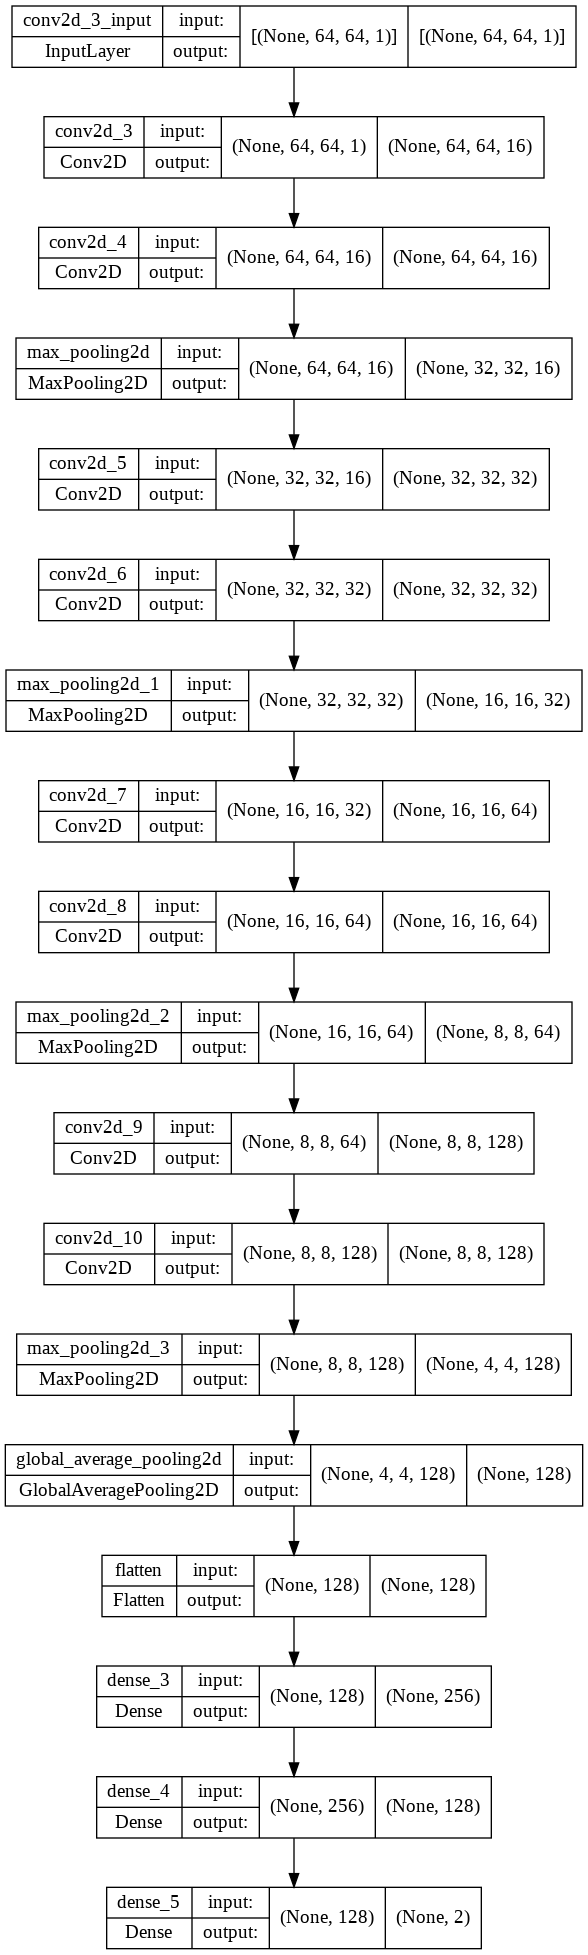

In [ ]:
plot_model(cnn, 
           to_file='model_plot.png', 
           show_shapes=True, 
           show_layer_names=True)

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

### CNN - V2

In [ ]:
def make_cnn_model(input_shape, classes=7):
  model = keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', 
                   input_shape=input_shape))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2, 2))
  model.add(keras.layers.Dropout(0.25))

  model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', 
                   input_shape=input_shape))
  model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2, 2))
  model.add(keras.layers.Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(keras.layers.Dropout(0.25))

  model.add(Dense(classes, activation='sigmoid'))


  
  return model

In [ ]:
model = make_cnn_model((64, 64, 1), 2)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 128)      

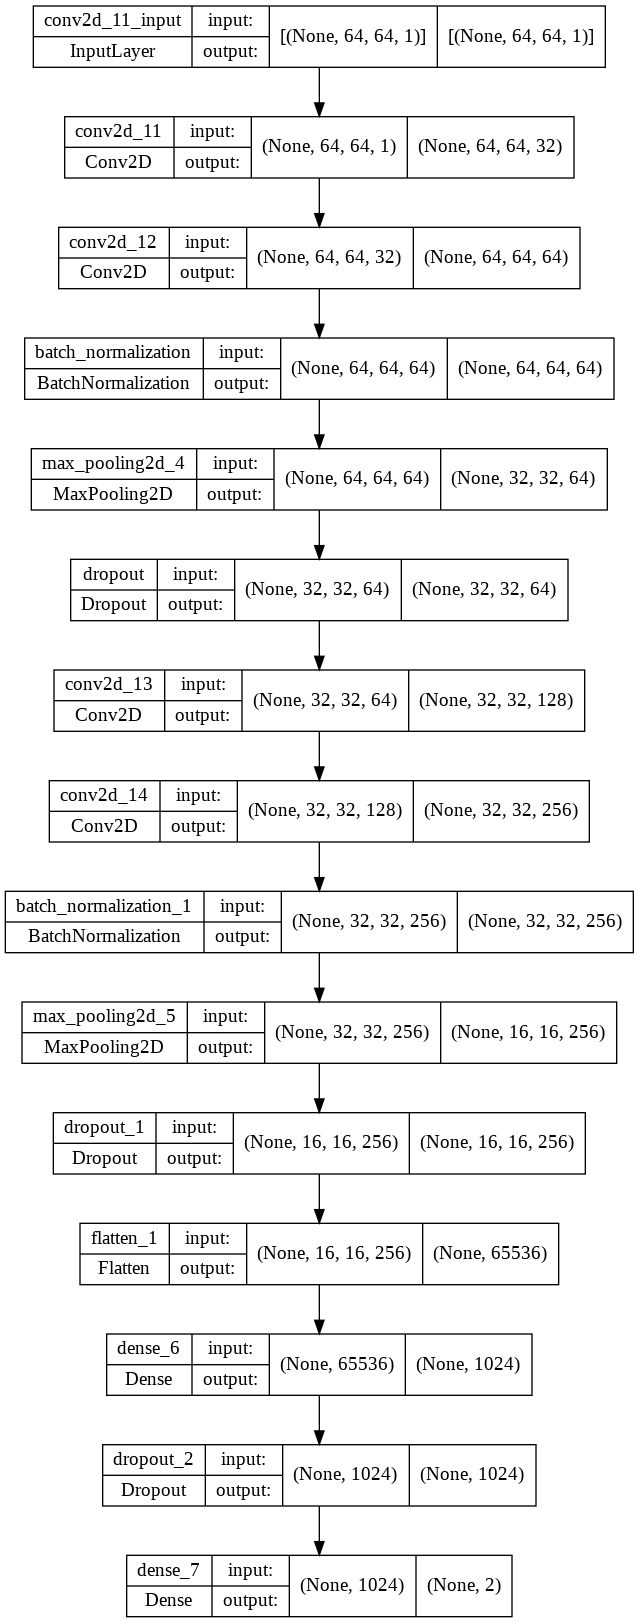

In [ ]:
plot_model(model, 
           to_file='model_plot.png', 
           show_shapes=True, 
           show_layer_names=True)

In [ ]:
# making model checkpoints
import datetime

path = '/content/lubg_model.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(path, 
                                                      save_best_only=True,
                                                      verbose=1,
                                                      mode='min',
                                                      moniter='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', 
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)
# model logs
csv_logger = keras.callbacks.CSVLogger('cnn_model_logs.csv', 
                       append=True)

callbacks = [model_checkpoint, reduce_lr, csv_logger]

# compiling the model
model.compile(loss='binary_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])

In [ ]:
%%time
EPOCHS=100
# fitting the model
history = model.fit(X_train, Y_train,
                    epochs=EPOCHS,  
                    verbose=1, 
                    callbacks=callbacks, 
                    validation_data=(X_test, Y_test)                    
                   )

Epoch 1/100
168/168 [==============================] - ETA: 0s - loss: 3.8783 - accuracy: 0.6979
Epoch 1: val_loss improved from inf to 29.59520, saving model to /content/lubg_model.h5
168/168 [==============================] - 21s 62ms/step - loss: 3.8783 - accuracy: 0.6979 - val_loss: 29.5952 - val_accuracy: 0.6206 - lr: 0.0010
Epoch 2/100
167/168 [============================>.] - ETA: 0s - loss: 0.3630 - accuracy: 0.8467
Epoch 2: val_loss improved from 29.59520 to 15.12447, saving model to /content/lubg_model.h5
168/168 [==============================] - 10s 59ms/step - loss: 0.3631 - accuracy: 0.8466 - val_loss: 15.1245 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 3/100
167/168 [============================>.] - ETA: 0s - loss: 0.2384 - accuracy: 0.9055
Epoch 3: val_loss improved from 15.12447 to 3.80683, saving model to /content/lubg_model.h5
168/168 [==============================] - 10s 58ms/step - loss: 0.2385 - accuracy: 0.9053 - val_loss: 3.8068 - val_accuracy: 0.7715 - lr: 0.0

In [ ]:
# making a function to calculate & show model history
def model_hist(history):
    accuracy = history['accuracy']
    loss = history['loss']
    val_accuracy = history['val_accuracy']
    val_loss = history['val_loss']
    
    # setting the epochs
    n_epochs = range(len(history['loss']))
    
    # saving models logs
    csv_logger = keras.callbacks.CSVLogger('cnn_model_logs.csv', 
                           append=True)
    
    # making plots for accuracy
    # plt.title('Training and Testing Accuracy') 
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)

    plt.plot(n_epochs, accuracy, label='training accuracy')
    # plt.yticks(np.arange(min(n_epochs), max(n_epochs) + 1, 0.1))

    plt.plot(n_epochs, val_accuracy, label='validation accuracy')
    # plt.yticks(np.arange(min(n_epochs), max(n_epochs) + 1, 0.1))

    plt.legend()
    
    # making plots for loss
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 2)
    plt.plot(n_epochs, loss, label='training loss (crossentropy loss)')
    plt.plot(n_epochs, val_loss, label='validation loss ( crossentropy loss)')
    plt.legend()
    
    return None

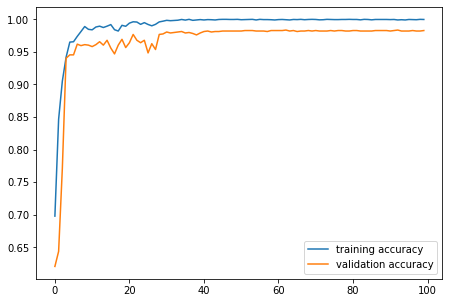

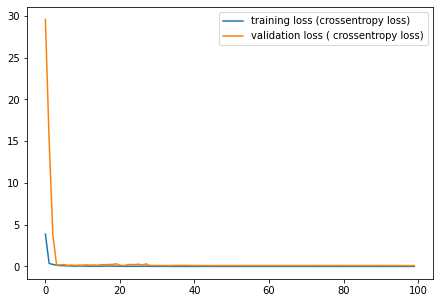

In [ ]:
hist = model.history.history
model_hist(hist)

In [ ]:
# calculate result of validation data
scores = model.evaluate(X_test, Y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

42/42 [==============================] - 0s 10ms/step - loss: 0.1026 - accuracy: 0.9828
accuracy: 98.28%


In [ ]:
y_hat = model.predict(X_test)
# y_pred_proba = np.argmax(y_hat)
y_pred = np.argmax(y_hat, axis=-1)

In [ ]:
y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
# print classification report
print(classification_report(np.argmax(Y_test, 1), y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       833
           1       0.98      0.97      0.98       506

    accuracy                           0.98      1339
   macro avg       0.98      0.98      0.98      1339
weighted avg       0.98      0.98      0.98      1339



In [ ]:
conf = confusion_matrix(np.argmax(Y_test, 1), y_pred)
conf

array([[823,  10],
       [ 13, 493]])

In [ ]:
TP = conf[1, 1]
TN = conf[0, 0] 
FP = conf[0, 1] 
FN = conf[1, 0]

In [ ]:
sens = TP / float(TP+FN)
sens

0.974308300395257

In [ ]:
spec = TN / float(TN+FP)
spec

0.9879951980792316

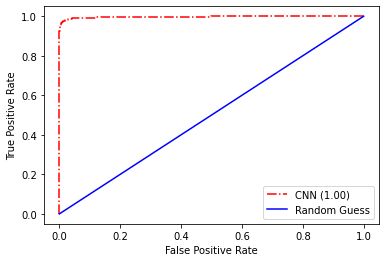

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(np.argmax(Y_test, 1), y_hat[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()

In [ ]:
# model.save('final_cnn_lnm_sd_model.h5')

### EfficientNet

In [ ]:
'''
# initializing efficientnet b7 cnn model
eff_7 = EfficientNetB7(
        weights='imagenet',
        include_top=False
        )

# setting trainable to false    
eff_7.trainable = False

# global avg pooling layer
x = keras.layers.GlobalAveragePooling2D()(eff_7.output)
# flatten layer
x = Flatten()(x)
# fully connected layer 1
x = Dense(128, activation='relu')(x)
# fully connected layer 2
x = Dense(64, activation='relu')(x)

# outout layer
y = Dense(2, activation='softmax')(x) # since we have 2 outputs, we will use 1 neuron in last layer

# setting up y = f(x)
# tie it together
model = keras.models.Model(inputs=eff_7.input, 
              outputs=y)
'''

"\n# initializing efficientnet b7 cnn model\neff_7 = EfficientNetB7(\n        weights='imagenet',\n        include_top=False\n        )\n\n# setting trainable to false    \neff_7.trainable = False\n\n# global avg pooling layer\nx = keras.layers.GlobalAveragePooling2D()(eff_7.output)\n# flatten layer\nx = Flatten()(x)\n# fully connected layer 1\nx = Dense(128, activation='relu')(x)\n# fully connected layer 2\nx = Dense(64, activation='relu')(x)\n\n# outout layer\ny = Dense(2, activation='softmax')(x) # since we have 2 outputs, we will use 1 neuron in last layer\n\n# setting up y = f(x)\n# tie it together\nmodel = keras.models.Model(inputs=eff_7.input, \n              outputs=y)\n"

### Model Compilation

In [ ]:
# compiling the model
cnn.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
  )

In [ ]:
callbacks = ModelCheckpoint('/content/model.h5', 
                            monitor='val_loss',
                            save_best_only=True, 
                            save_weights_only=True)

In [ ]:
# for loss
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') >= 0.995:
                print('\nAcc is achieved so cancelling training')
                self.model.stop_training=True
my_callback = myCallback()

### Model Fitting

In [ ]:
%%time
history = cnn.fit(X_train,
                  Y_train, 
                  epochs=50, 
                  verbose=1,
                  validation_data=(X_test, Y_test))

Epoch 1/50
168/168 [==============================] - 3s 14ms/step - loss: 0.6660 - accuracy: 0.6224 - val_loss: 0.6626 - val_accuracy: 0.6221
Epoch 2/50
168/168 [==============================] - 2s 9ms/step - loss: 0.6640 - accuracy: 0.6226 - val_loss: 0.6630 - val_accuracy: 0.6221
Epoch 3/50
168/168 [==============================] - 2s 10ms/step - loss: 0.6642 - accuracy: 0.6226 - val_loss: 0.6631 - val_accuracy: 0.6221
Epoch 4/50
168/168 [==============================] - 2s 10ms/step - loss: 0.6634 - accuracy: 0.6226 - val_loss: 0.6701 - val_accuracy: 0.6221
Epoch 5/50
168/168 [==============================] - 2s 10ms/step - loss: 0.6641 - accuracy: 0.6226 - val_loss: 0.6639 - val_accuracy: 0.6221
Epoch 6/50
168/168 [==============================] - 2s 10ms/step - loss: 0.6634 - accuracy: 0.6226 - val_loss: 0.6634 - val_accuracy: 0.6221
Epoch 7/50
168/168 [==============================] - 2s 10ms/step - loss: 0.6638 - accuracy: 0.6214 - val_loss: 0.6646 - val_accuracy: 0.6221


In [ ]:
# saving the model
cnn.save('model_94acc.h5')

In [ ]:
# making a function to calculate & show model history
def model_hist(history):
    accuracy = history['accuracy']
    loss = history['loss']
    val_accuracy = history['val_accuracy']
    val_loss = history['val_loss']
    
    # setting the epochs
    n_epochs = range(len(history['loss']))
    
    # saving models logs
    csv_logger = keras.callbacks.CSVLogger('cnn_model_logs.csv', 
                           append=True)
    
    # making plots for accuracy
    # plt.title('Training and Testing Accuracy') 
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)

    plt.plot(n_epochs, accuracy, label='training accuracy')
    # plt.yticks(np.arange(min(n_epochs), max(n_epochs) + 1, 0.1))

    plt.plot(n_epochs, val_accuracy, label='validation accuracy')
    # plt.yticks(np.arange(min(n_epochs), max(n_epochs) + 1, 0.1))

    plt.legend()
    
    # making plots for loss
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 2)
    plt.plot(n_epochs, loss, label='training loss (crossentropy loss)')
    plt.plot(n_epochs, val_loss, label='validation loss ( crossentropy loss)')
    plt.legend()
    
    return None

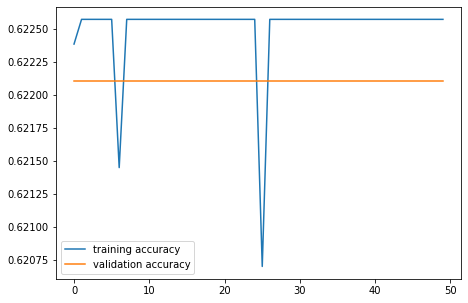

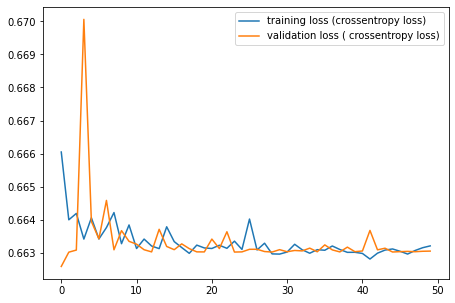

In [ ]:
hist = history.history
model_hist(hist)

In [ ]:
# calculate result of validation data
scores = cnn.evaluate(X_test, Y_test)
print("%s: %.2f%%" % (cnn.metrics_names[1], scores[1] * 100))

42/42 [==============================] - 0s 5ms/step - loss: 0.6631 - accuracy: 0.6221
accuracy: 62.21%


In [ ]:
y_hat = cnn.predict(X_test)
# y_pred_proba = np.argmax(y_hat)
y_pred = np.argmax(y_hat, axis=-1)

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

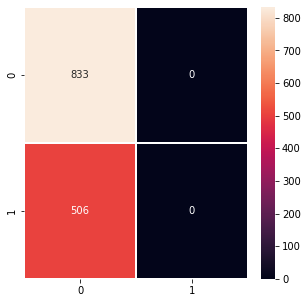

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       833
           1       0.00      0.00      0.00       506

    accuracy                           0.62      1339
   macro avg       0.31      0.50      0.38      1339
weighted avg       0.39      0.62      0.48      1339



In [ ]:
import warnings
warnings.filterwarnings("ignore")

conf = confusion_matrix(np.argmax(Y_test, 1), y_pred)
conf

import seaborn as sns
import matplotlib.pyplot as plt 
f, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(conf, annot = True, linewidths = 0.5, fmt = ".0f", ax = ax) 
plt.show()

# print classification report
print(classification_report(np.argmax(Y_test, 1), y_pred))

In [ ]:
TP = conf[1, 1]
TN = conf[0, 0] 
FP = conf[0, 1] 
FN = conf[1, 0]

In [ ]:
sens = TP / float(TP+FN)
sens

0.0

In [ ]:
spec = TN / float(TN+FP)
spec

1.0

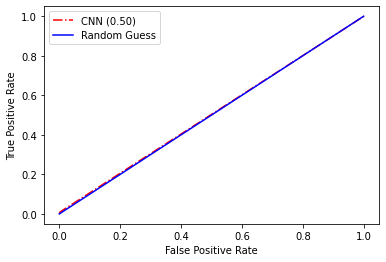

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(np.argmax(Y_test, 1), y_hat[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()